In [1]:
import os
import sys
import time
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import vaex as vx
%matplotlib inline

In [2]:
def get_all(pattern, columns=None):
    if (not isinstance(columns, list)):
        print("If no list of keys is input, then all are retrieved")
    tabls = []
    counter = True
    t0 = time.time()
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for idx, f in enumerate(filenm):
            if (pattern in f):
                tabls.append(f)
                hdu = fitsio.FITS(f)
                if counter:
                    if (columns is None):
                        r_arr = hdu[1].read()
                    else:
                        r_arr = hdu[1].read()[columns]
                    counter = False
                else:
                    if (columns is None):
                        r_arr = np.concatenate((r_arr, hdu[1].read()))
                    else:
                        r_arr = np.concatenate((r_arr, hdu[1].read()[columns]))
                hdu.close()
                print("{0} loaded".format(f))
    print("Elapsed time in reading the FITS: {0:.2f} min".format((time.time() - t0) / 60.))
    return r_arr

In [3]:
# Read the A, B, and THETA info
abt = get_all("DR1_MAIN_ABTHETA_")
# Sort it
idx_abt = np.argsort(abt["COADD_OBJECT_ID"])
abt = abt[idx_abt]

If no list of keys is input, then all are retrieved
DR1_MAIN_ABTHETA_000001.fits loaded
DR1_MAIN_ABTHETA_000002.fits loaded
DR1_MAIN_ABTHETA_000003.fits loaded
DR1_MAIN_ABTHETA_000004.fits loaded
DR1_MAIN_ABTHETA_000005.fits loaded
DR1_MAIN_ABTHETA_000006.fits loaded
DR1_MAIN_ABTHETA_000007.fits loaded
Elapsed time in reading the FITS: 1.29 min


In [4]:
# Read the Star/Galaxy separation table: ('COADD_OBJECT_ID', 'EXT_WAVG', 'EXT_COADD')
sg = get_all("BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_")
# Sort it
idx_sg = np.argsort(sg["EXT_WAVG"])
sg = sg[idx_sg]

If no list of keys is input, then all are retrieved
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000001.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000002.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000003.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000004.fits loaded
BECHTOL.Y3A2_EXT_MASH_V2_WAVG_COADD_000005.fits loaded
Elapsed time in reading the FITS: 0.68 min


In [44]:
print("Percentage of the total sample: {0:.2f}%".format(abt.shape[0]/4.e8 * 100.))

Percentage of the total sample: 57.38%


In [5]:
# Split COADD_OBJ_ID in groups, using the WAVG classificator
aux_sg = [sg[np.where(sg["EXT_WAVG"] == x)]["COADD_OBJECT_ID"] for x in [0, 1, 2, 3]]

In [7]:
# Using the objects IDs, get the indices of each of the d/g classes
xm_sg_idx = [np.where(np.in1d(abt["COADD_OBJECT_ID"], subclassif)) for subclassif in aux_sg]
print("xmatch was successful")

xmatch was successful


In [16]:
print("Columns and its data types: \n\t{0} \n\t{1}".format(abt.dtype, sg.dtype))

Columns and its data types: 
	[('A_IMAGE', '>f8'), ('B_IMAGE', '>f8'), ('THETA_J2000', '>f8'), ('COADD_OBJECT_ID', '>i8')] 
	[('COADD_OBJECT_ID', '>i8'), ('EXT_WAVG', '>i2'), ('EXT_COADD', '>i2')]


In [12]:
# Using each one of the classes separately, do the A, B, THETA distributions
# Import into vaex
# Data for star classifications
ds0 = vx.from_arrays(A=abt[xm_sg_idx[0]]["A_IMAGE"], B=abt[xm_sg_idx[0]]["B_IMAGE"], 
                     T=abt[xm_sg_idx[0]]["THETA_J2000"]
                    )
ds1 = vx.from_arrays(A=abt[xm_sg_idx[1]]["A_IMAGE"], B=abt[xm_sg_idx[1]]["B_IMAGE"], 
                     T=abt[xm_sg_idx[1]]["THETA_J2000"]
                    )

In [13]:
# Data for galaxy classifications
ds2 = vx.from_arrays(A=abt[xm_sg_idx[2]]["A_IMAGE"], B=abt[xm_sg_idx[2]]["B_IMAGE"], 
                     T=abt[xm_sg_idx[2]]["THETA_J2000"]
                    )
ds3 = vx.from_arrays(A=abt[xm_sg_idx[3]]["A_IMAGE"], B=abt[xm_sg_idx[3]]["B_IMAGE"], 
                     T=abt[xm_sg_idx[3]]["THETA_J2000"]
                    )

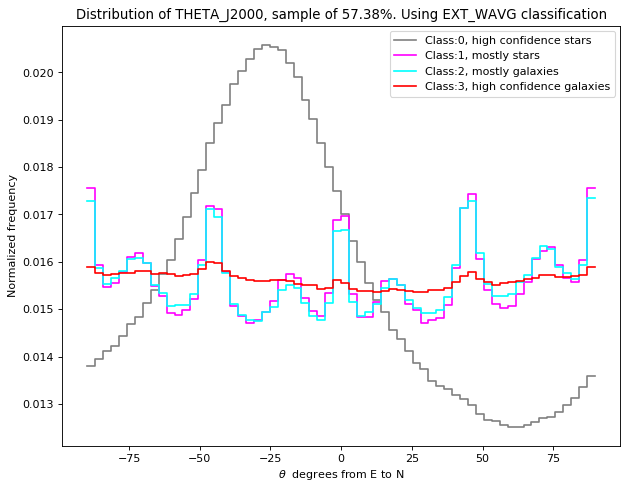

In [56]:
# Theta distribution
kw = {
    "what": "count(*)",
    "n": "normalize",
}
a = ds0.plot1d("T", color="gray", label="Class:0, high confidence stars", figsize=(8,6), **kw)
a = ds1.plot1d("T", color="magenta", label="Class:1, mostly stars", **kw)
a = ds2.plot1d("T", color="cyan", label="Class:2, mostly galaxies", **kw)
a = ds3.plot1d("T", color="red", label="Class:3, high confidence galaxies", **kw)
plt.legend(loc="upper right", fancybox=True)
plt.xlabel(r"$\theta$  degrees from E to N")
plt.ylabel("Normalized frequency")
plt.title(r"Distribution of THETA_J2000, sample of {0:.2f}%. Using EXT_WAVG classification".format(abt.shape[0]/4.e8 * 100.))
plt.savefig("theta_subsample.png", format="png", dpi=500)